Synchronize DLC results with xr_session

In [63]:
%reload_ext autoreload
%autoreload 2
from trialexp.process.deeplabcut import utils as dlc_utils
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import Video
import seaborn as sns
from trialexp.process.pyphotometry.utils import make_event_xr, extract_event_data

In [2]:
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/'
videofile = session_path +f'video/{fn}.mp4'

# Load DLC results

In [3]:
dftip = pd.read_pickle('dftip.pkl')
dfwrist = pd.read_pickle('dfwrist.pkl')

In [4]:
def add_video_timestamp(df,videofile):
    # add timestamp of the video file to the deeplabcut dataframe
    ts = dlc_utils.extract_video_timestamp(videofile)
    df['time'] = ts
    df = df.set_index('time')
    return df

dftip = dlc_utils.add_video_timestamp(dftip, videofile)
dfwrist = dlc_utils.add_video_timestamp(dfwrist, videofile)
    

In [5]:
xr_dlc = xr.DataArray([dfwrist,dftip], dims=('marker','time','coords'),
                 coords={'marker':['wrist','tip'],
                         'time':dfwrist.index,
                         'coords':['x','y','likelihood']
                 })

## Synchronize with the xr_session

In [6]:
xr_session = xr.open_dataset(session_path+'/processed/xr_session.nc')

# resample to the xr_session time
xr_dlc = xr_dlc.interp(time=xr_session.time)
xr_session['dlc_markers'] = xr_dlc

In [7]:
xr_session.to_netcdf('xr_session_dlc.nc', engine='h5netcdf')

In [8]:
wrist_loc = xr_session['dlc_markers'].loc['wrist',:,['x','y']]
tip_loc = xr_session['dlc_markers'].loc['tip',:,['x','y']]

## Get the photometry signal based on speed trigger

In [9]:
signal_time, coords, speed = dlc_utils.get_marker_signal(wrist_loc)

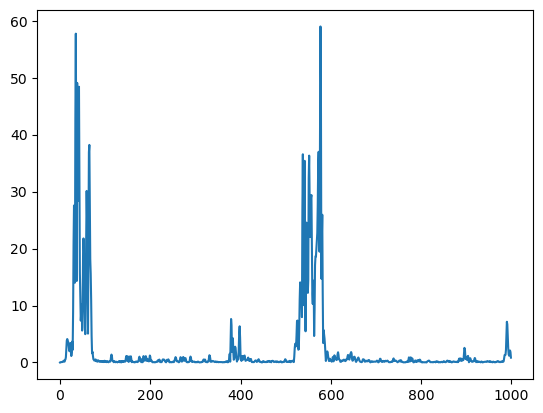

In [11]:
plt.plot(speed[:1000])

In [18]:
f = xr_session.zscored_df_over_f.data[0]
accel = np.diff(speed,prepend=speed[0])

df_vigor = pd.DataFrame({
    'accel': accel,
    'speed': speed,
    'df/f': f})
df_vigor

,accel,speed,df/f
0,0.000000,0.000000,0.205254
1,0.057733,0.057733,0.292358
2,-0.014141,0.043592,0.262030
3,0.027108,0.070699,0.201862
4,0.015841,0.086541,0.231352
...,...,...,...
176423,0.047227,0.658829,0.003056
176424,2.613453,3.272282,0.031638
176425,1.856771,5.129054,0.086082
176426,-0.771006,4.358047,0.064148


<Axes: xlabel='accel', ylabel='df/f'>

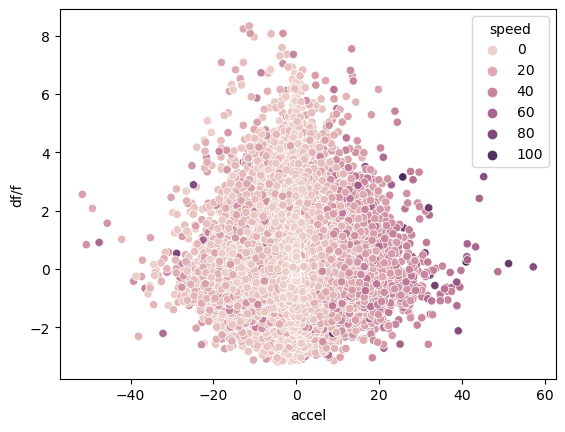

In [21]:
sns.scatterplot(df_vigor, x='accel', y='df/f', hue='speed')

<Axes: xlabel='speed', ylabel='df/f'>

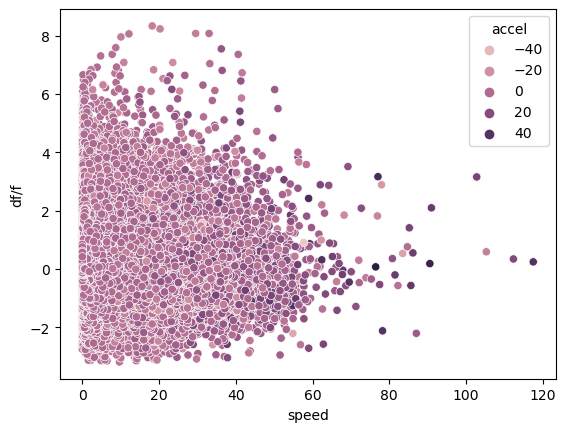

In [23]:
sns.scatterplot(df_vigor, x='speed', y='df/f', hue='accel')

## Identify contagious regions

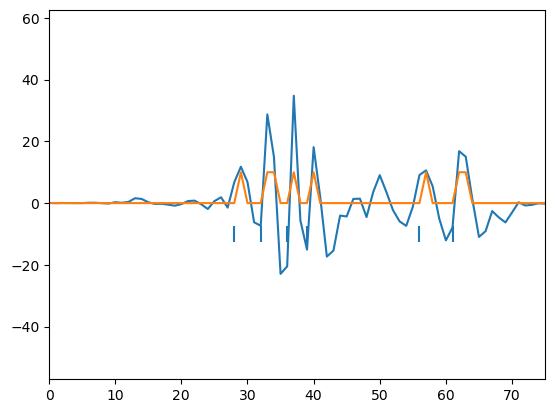

In [55]:
fig,ax = plt.subplots()

a = np.diff(speed)
ax.plot(a)
ax.plot((a>10)*10)
ax.set_xlim([0,75])

condition  = (a>10).astype(np.int8)
event_idx = np.where(np.diff(condition)==1)[0]
ax.eventplot(event_idx, lineoffset=-10, linelength=5)

event_time = xr_session.time[event_idx]

In [56]:
event_time

<xarray.DataArray 'time' (time: 2153)>
array([   7888.5,    7928.5,    7968.5, ..., 1767927.5, 1770467.5, 1770647.5])
Coordinates:
  * time     (time) float64 7.888e+03 7.928e+03 7.968e+03 ... 1.77e+06 1.771e+06

(0.0, 200.0)

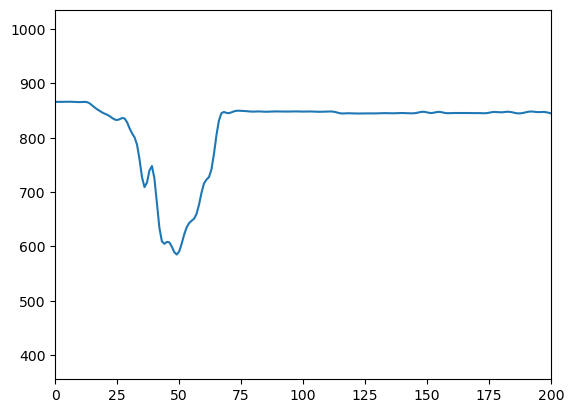

In [33]:
plt.plot(coords[:,0])
plt.xlim([0,200])

In [88]:
trial_window = xr_session.trial_window
sampling_rate = xr_session.attrs['sampling_rate']
event_period = (trial_window[1] - trial_window[0])/1000
event_time_coord= np.linspace(trial_window[0], trial_window[1], int(event_period*sampling_rate)) #TODO

#note the event time here refer to the relative time
data, _ = extract_event_data(event_time, trial_window, xr_session['zscored_df_over_f'], sampling_rate)


-1972 3028 0.0
-1968 3032 0.0
-1964 3036 0.0
-1961 3039 0.0
-1944 3056 0.0
-1939 3061 0.0
-1465 3535 0.0
-1461 3539 0.0
-1457 3543 0.0
-1451 3549 0.0
-1426 3574 0.0
-971 4029 0.0
-967 4033 0.0
-962 4038 0.0
-958 4042 0.0
-952 4048 0.0
-592 4408 0.0
-252 4748 0.0
-248 4752 0.0
-218 4782 0.0
-172 4828 0.0
-164 4836 0.0
-156 4844 0.0
-127 4873 0.0
-97 4903 0.0
50 5050 0.0
69 5069 0.0
73 5073 0.0
79 5079 0.0
88 5088 0.0
92 5092 0.0
239 5239 0.0
782 5782 0.0
1761 6761 0.0
2967 7967 0.0
2975 7975 0.0
2979 7979 0.0
2983 7983 0.0
3414 8414 0.0
3423 8423 0.0
3506 8506 0.0
3519 8519 0.0
3523 8523 0.0
3527 8527 0.0
3600 8600 0.0
3945 8945 0.0
4074 9074 0.0
4448 9448 0.0
4525 9525 0.0
4977 9977 0.0
4986 9986 0.0
4989 9989 0.0
5079 10079 0.0
5536 10536 0.0
5542 10542 0.0
5546 10546 0.0
5549 10549 0.0
5555 10555 0.0
5559 10559 0.0
6108 11108 0.0
6115 11115 0.0
6121 11121 0.0
6145 11145 0.0
6149 11149 0.0
6221 11221 0.0
6417 11417 0.0
6478 11478 0.0
6681 11681 0.0
6711 11711 0.0
6715 11715 0.0
6771 1

In [86]:
d = abs(xr_session.time-event_time[0]).data
np.argmin(d)

28

In [75]:
da = xr.DataArray(
        data, coords={'event_time':event_time_coord,
                     'event_index': np.arange(data.shape[0])},
                        dims=('event_index','event_time'))

In [76]:
da

<xarray.DataArray (event_index: 2153, event_time: 5000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * event_time   (event_time) float64 -2e+03 -1.999e+03 ... 2.999e+03 3e+03
  * event_index  (event_index) int64 0 1 2 3 4 5 ... 2148 2149 2150 2151 2152

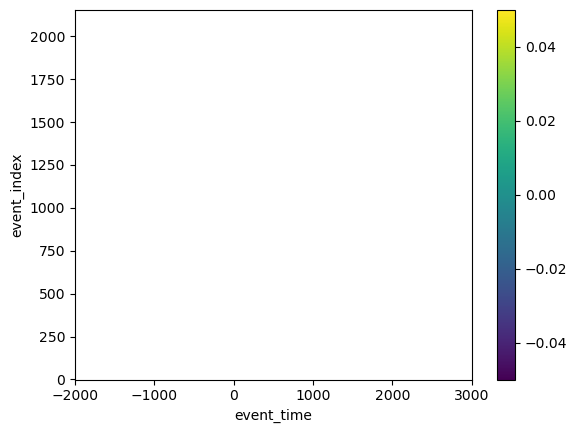

In [77]:
da.plot()